In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

def read_files(files):
    data = []
    for f in files:
        data += [pd.read_csv(f, sep=',', skipinitialspace=True)]
    return data

In [221]:
def fit(f, par, x, y):
    """Аргументы:
    f - функция, которую мы хотим оптимизировать.
    params - начальное состояние параметров, можно просто передать нули,
    главное чтоб их было нужное количество
    x, y - точки, под которые подгоняем функцию
    """
    if len(x) != len(y):
        raise "Иксов должно быть столько же, сколько и игреков"
    def err(par, x_, y_):
        y1 = f(par, x_)
        return np.sum((y1-y_)**2)
    return minimize(err, par, args=(x, y)).x

In [222]:
def latex_tab(df, caption):
    tab = df.to_latex(float_format='%.3f',
                      caption=caption,
                      escape=False,
                      index=False,
                      position='H')

    tab = tab.replace('\\\\\n', '\\\\ \\hline\n')
    tab = tab.replace('I(mA)', r'$I$, мА')
    tab = tab.replace('U(V)', r'$U$, В')
    tab = tab.replace('Q &', r'$Q$, мВт &')
    tab = tab.replace('R &', r'$R$, Ом &')
    tab = tab.replace('\\toprule', '\\hline')
    tab = tab.replace('\\midrule\n', '')
    tab = tab.replace('rrrrrr', '|c|c|c|c|c|c|')
    tab = tab.replace('\\bottomrule\n', '')
    return tab


In [223]:
# Давления в 1 п. лабы

P_lim = [69.45, 4304.46]
P_atm = 99.71 * 1e3

inv_P = [1 / P_lim[1] + i / 6 * (1 / P_lim[0] - 1 / P_lim[1]) for i in range(7)]
inv_P += [1 / P_atm + i / 4 * (1 / P_lim[1] - 1 / P_atm) for i in range(4)]
P = [1 / p for p in inv_P]
P.sort()
P

[69.45,
 83.0719363645837,
 103.34132342824749,
 136.694512232762,
 201.83695244139577,
 385.5933585713642,
 4304.46,
 5657.8637324185265,
 8252.654613598917,
 15243.64502645898,
 99710.0]

In [224]:
FIGSIZE = (8, 4)

In [225]:
[load] = read_files(['data/QR.csv'])

I = load['I(mA)']
U = load['U(V)']

# Ток и напряжение
R = 1e3 * U / I
Q = U * I

load['R'] = R
load['Q'] = Q

rel_err = np.sqrt((0.001 / I)**2 + (0.001 / U)**2)
R_err = R * rel_err
Q_err = Q * rel_err

x_ax = np.linspace(0, max(Q), 1000)
[A, B], cov = np.polyfit(Q, R, deg=1, cov=True)
cov = np.sqrt(np.diag(cov))
A_err = cov[0]
B_err = cov[1]

In [226]:
B_err / B

0.0006049370588530067

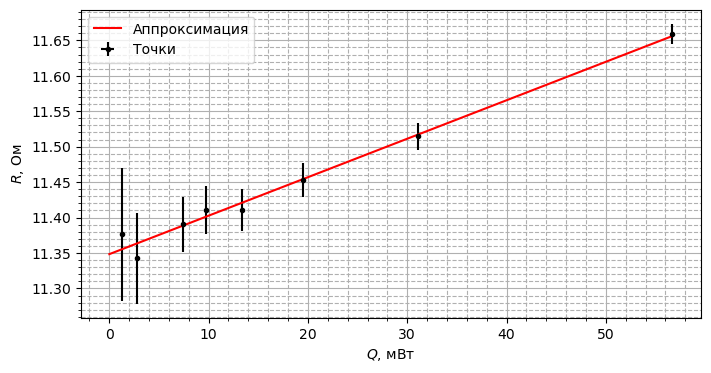

In [227]:
plt.figure(figsize=FIGSIZE)
plt.minorticks_on()

plt.errorbar(Q, R, fmt='k.', label='Точки', xerr=Q_err, yerr=R_err)
plt.plot(x_ax, A * x_ax + B, label='Аппроксимация', color='red')

plt.xlabel('$Q$, мВт')
plt.ylabel('$R$, Ом')

plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.legend()
plt.savefig('graphs/QR.pdf')

In [228]:
ALPHA = 3.92e-3
T_K = 25

R_k = B
R_k

11.348375455934322

In [229]:
R0 = R_k / (1 + ALPHA * T_K)
R0

10.33549677225348

In [297]:
def plot_press(press, name, colors, fmts):
    plt.figure(figsize=FIGSIZE)
    plt.minorticks_on()

    A = []
    B = []
    A_err = []

    for i in range(len(press)):
        [data] = read_files([f'data/UI{press[i]}.csv'])
        U = data['U(V)']
        I = data['I(mA)']
        rel_err = np.sqrt((0.001 / I)**2 + (0.001 / U)**2)

        T = ((1e3 * U / I) / R0 - 1) / ALPHA
        T_err = (T + 273) * rel_err
        Q = U * I
        Q_err = Q * rel_err
        [a, b], cov = np.polyfit(Q, T, deg=1, cov=True)
        cov = np.sqrt(np.diag(cov))
        A.append(a)
        B.append(b)
        A_err.append(cov[0] / 2)

        x_ax = np.linspace(0, 60, 1000)

        plt.errorbar(Q, T, fmt=fmts[i], xerr=Q_err, yerr=T_err)
        plt.plot(x_ax, a * x_ax + b, label=f'$P = {press[i]: .0f}$ Па', color=colors[i])

    plt.xlabel('$Q$, мВт')
    plt.ylabel('$T, ^{\circ}$C')

    plt.grid(which='major')
    plt.grid(which='minor', linestyle='--')
    plt.legend()
    plt.savefig(f'graphs/QT_{name}.pdf')

    return [A, B, A_err]

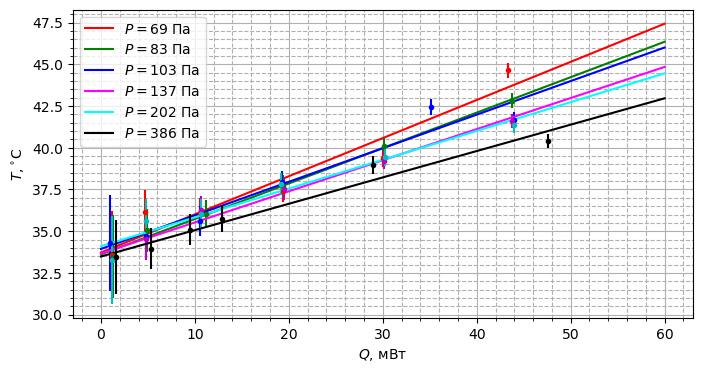

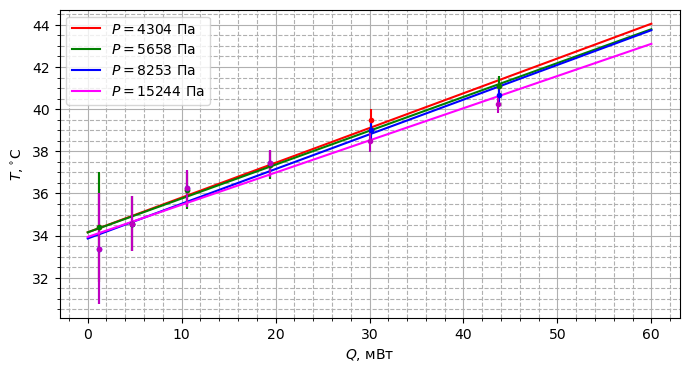

In [298]:
low_press = P[:6]
high_press = P[6:10]
press = low_press + high_press

colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'black']
fmts = ['r.', 'g.', 'b.', 'm.', 'c.', 'k.']

[k_low, t_low, k_err_high] = plot_press(low_press, 'lowpress', colors, fmts)
[k_high, t_high, k_err_low] = plot_press(high_press, 'highpress', colors, fmts)
k_all = k_low + k_high
t_all = t_low + t_high
k_err = k_err_low + k_err_high

In [299]:
for i in range(len(k_all)):
    k_all[i] *= 1e3
    k_err[i] *= 1e3

k_table = pd.DataFrame()
k_table['$P$, Па'] = press
k_table['$K$, К/Вт'] = k_all
k_table['$T(0)$, \\textdegree C'] = t_all

print(latex_tab(k_table, caption='Зависимость $K(P)$'))

\begin{table}[H]
\centering
\caption{Зависимость $K(P)$}
\begin{tabular}{rrr}
\hline
  $P$, Па &  $K$, К/Вт &  $T(0)$, \textdegree C \\ \hline
   69.450 &    228.392 &                 33.726 \\ \hline
   83.072 &    212.266 &                 33.613 \\ \hline
  103.341 &    201.088 &                 33.939 \\ \hline
  136.695 &    186.223 &                 33.667 \\ \hline
  201.837 &    172.586 &                 34.103 \\ \hline
  385.593 &    157.954 &                 33.485 \\ \hline
 4304.460 &    164.894 &                 34.157 \\ \hline
 5657.864 &    160.588 &                 34.156 \\ \hline
 8252.655 &    164.618 &                 33.866 \\ \hline
15243.645 &    152.657 &                 33.938 \\ \hline
\end{tabular}
\end{table}



/tmp/ipykernel_9732/2853851936.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab = df.to_latex(float_format='%.3f',


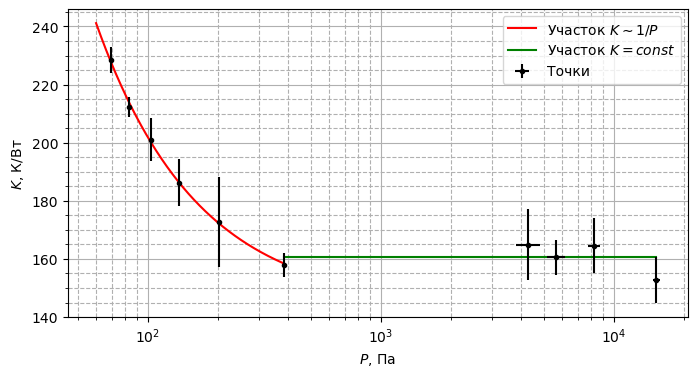

In [300]:
x_ax = np.linspace(60, press[5], 10000)

def f(par, x):
    return par[0] + par[1] / x

par = [0] * 2
par = fit(f, par, press[:6], k_all[:6])

mean = np.mean(k_all[6:])

plt.figure(figsize=FIGSIZE)
plt.minorticks_on()
plt.xscale('log')

LOW_ERR = 1
HIGH_ERR = 500

xerr = [LOW_ERR] * 6 + [HIGH_ERR] * 4

plt.plot(x_ax, f(par, x_ax), label='Участок $K\\sim 1/P$', color='red')

x_ax = np.linspace(press[5], max(press), 1000)
plt.plot(x_ax, [mean] * len(x_ax), label='Участок $K=const$', color='green')
plt.errorbar(press, k_all, fmt='k.', label='Точки', xerr=xerr, yerr=k_err)

plt.xlabel('$P$, Па')
plt.ylabel('$K$, К/Вт')
plt.legend()

plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.savefig('graphs/KP.pdf')

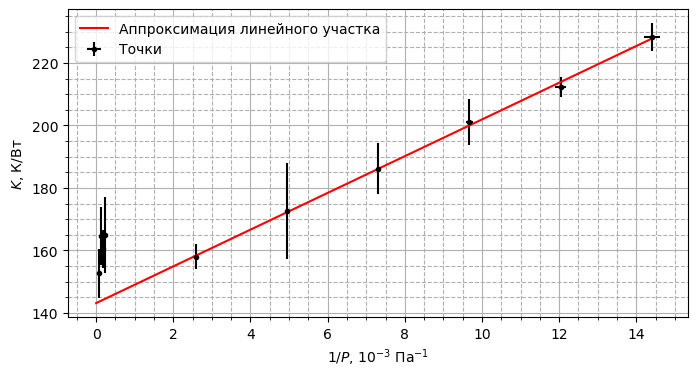

In [303]:
plt.figure(figsize=FIGSIZE)
plt.minorticks_on()

inv_P = [1e3 / p for p in press]
inv_err = [(inv_P[i] * xerr[i] / press[i]) for i in range(len(press))]

[A, B], cov = np.polyfit(inv_P[:6], k_all[:6], deg=1, cov=True)
x_ax = np.linspace(0, max(inv_P[:6]), 1000)

plt.errorbar(inv_P, k_all, fmt='k.', label='Точки', xerr=inv_err, yerr=k_err)
plt.plot(x_ax, A * x_ax + B, color='red', label='Аппроксимация линейного участка')
plt.xlabel('$1 / P$, $10^{-3}$ Па$^{-1}$')
plt.ylabel('$K$, К/Вт')
plt.legend()

plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.savefig('graphs/KP_lin.pdf')

In [302]:
[A, B]

[5.882224844199378, 143.1087210499121]

In [304]:
cov = np.sqrt(np.diag(cov))
cov[0]

0.10715880529448439

In [305]:
cov[1]

1.0077704643174128